# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation and Analysis.

In [382]:
import pandas as pd
import numpy as np
import math 
!pip install sidetable
import sidetable as stb
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [383]:
#first upload to check for missing data.
data=pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
data.stb.missing(style=True) 

,missing,total,percent
datetime,0,"26,496",0.00%
num_orders,0,"26,496",0.00%


No missing values.

In [384]:
#Now we upload the data agin however this time the date column will be converted to index.

data=pd.read_csv('/datasets/taxi.csv', parse_dates=[0],index_col=0)

In [385]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [386]:
data=data.sort_index()

In [387]:
#Let's check if the data is in in chronological order.

data.index.is_monotonic

True

The data in chronological order.

In [388]:
#Let's resample the data by 1W.

data=data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [389]:
data['num_orders'].unique()

array([124,  85,  71,  66,  43,   6,  12,  15,  34,  69,  64,  96,  30,
        32,  48,  44,  73,  45,  61, 113,  58,  90, 120,  75,  20,  11,
         7,  46,  54,  91,  36,  59,  82,  83,  89,  49,  93, 101, 119,
        72, 163, 108,  25,   9,  17,  56,  52,  57,  28,  41,  76,  68,
        63,  60,  26,  42,  27,  22,  39,  19,  51,  80,  77,  86, 176,
        16,   3,  14,  31,  50,  62,  37,  40,  47,  10,  81, 100, 121,
        24,  38,  55,  99, 127,  94, 143,  78,  65,  97, 114,  88,  79,
        84,  29,   1,   4,  70, 117,   5,  18,  53, 102,  33, 107, 118,
       153, 105,  67,  35, 109,  21,   8, 123, 110, 134, 133, 137, 126,
        13,  74,  95, 139,  87, 106,  92, 148, 182, 104, 131,  98,   2,
       112, 103, 128, 166, 111,  23,   0, 129, 164, 165, 138, 142, 159,
       115, 130, 135, 150, 167, 147, 253, 140, 172, 116, 125, 162, 201,
       136, 146, 154, 145, 155, 158, 156, 193, 197, 234, 157, 122, 144,
       149, 171, 152, 174, 186, 132, 194, 183, 188, 229, 173, 18

The data is resampled.

Let's see the distribution of number of orders.

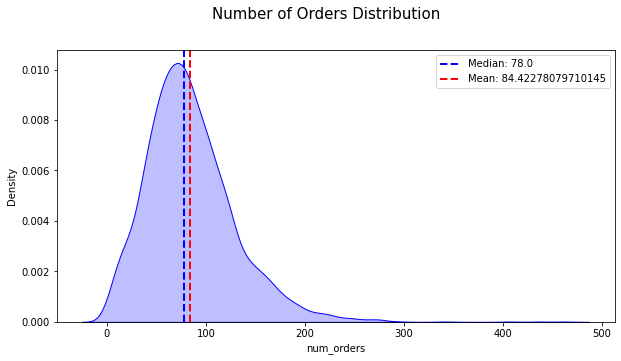

In [390]:
fig = plt.figure(figsize =(10, 5))
fig.suptitle('Number of Orders Distribution', fontsize=15, y=1)
sns.kdeplot(data['num_orders'], fill = True, color = 'blue')
plt.axvline(x = data['num_orders'].median(),
 color='blue',
 ls='--', 
 lw=2, 
 label = 'Median: {}'.format(data['num_orders'].median()))
plt.axvline(x = data['num_orders'].mean(),
 color='red',
 ls='--', 
 lw=2, 
 label = 'Mean: {}'.format(data['num_orders'].mean()))
plt.legend()
plt.show()


Let's see the time series plot with rolling mean.

<AxesSubplot:title={'center':'Time Series Plot'}, xlabel='datetime'>

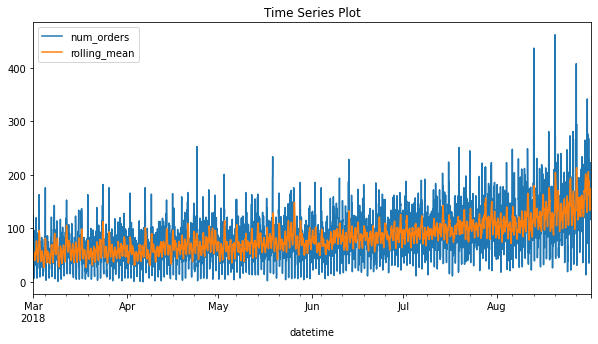

In [391]:
data['rolling_mean'] =data.rolling(10).mean() # < write code here >
data.plot(figsize=(10,5), title= 'Time Series Plot')

We see that demand for the taxi increases in summer time because in summer more people go to vacaition.

In [392]:
from statsmodels.tsa.seasonal import seasonal_decompose

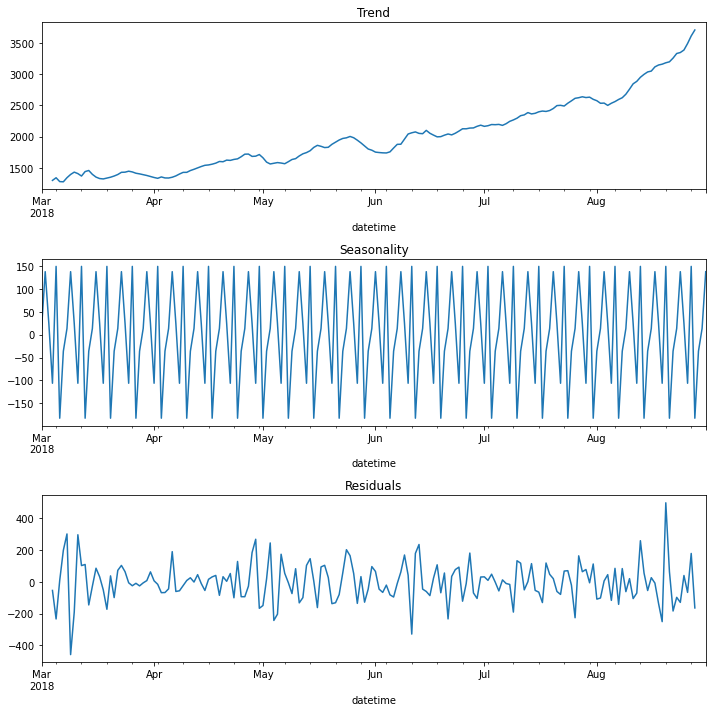

In [393]:
data_new=data['num_orders'].resample('1D').sum()
decomposed = seasonal_decompose( data_new)# < write code here >

plt.figure(figsize=(10, 10))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
# < write code here >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
# < write code here >
plt.title('Residuals')
plt.tight_layout()

The trend shows that there is increase of taxi demand from April to August which is logical because as I mentioned before in summer time there are more people go to vacation.

<AxesSubplot:xlabel='datetime'>

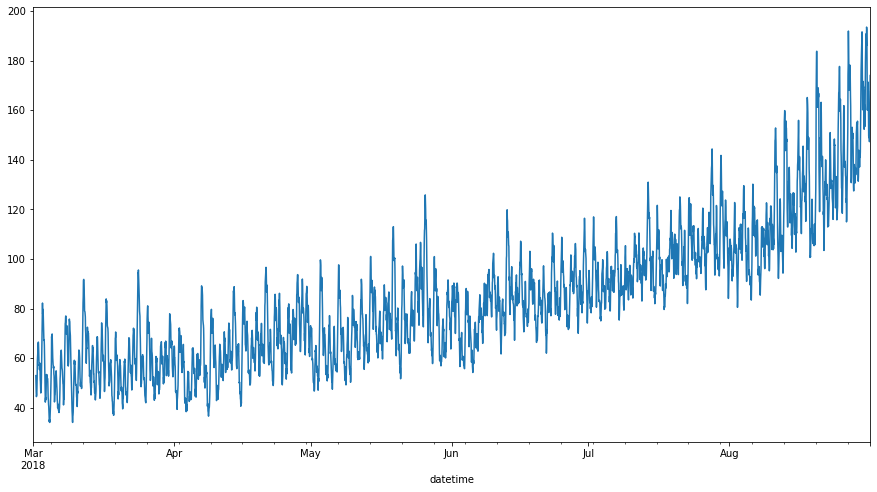

In [394]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['mean'].plot(figsize=(15,8)) 

<AxesSubplot:xlabel='datetime'>

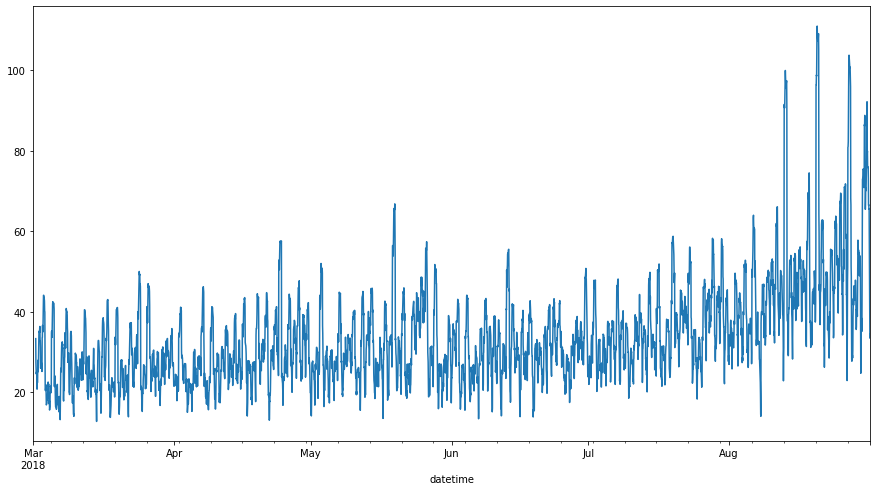

In [395]:
data['std'] = data['num_orders'].rolling(15).std()
data['std'].plot(figsize=(15,8)) 

From the plots of mean and std the conclusion is that the graphs are nonstationary.

## Training

Let's create a function for features.

In [396]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    return data

In [397]:
#Seting the size of max lag and rolling mean.

#make_features(data.drop(['std'],axis=1), 20, 20)
make_features(data, 20, 20)

,num_orders,rolling_mean,mean,std,year,month,day,dayofweek,lag_1,lag_2,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,2018,3,1,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,2018,3,1,3,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN,2018,3,1,3,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN,2018,3,1,3,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,NaN,2018,3,1,3,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,169.35,147.333333,57.917018,2018,8,31,4,207.0,217.0,...,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0
2018-08-31 20:00:00,154,163.85,152.400000,54.650578,2018,8,31,4,136.0,207.0,...,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0
2018-08-31 21:00:00,159,157.75,160.666667,43.955605,2018,8,31,4,154.0,136.0,...,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0


Let's split the data for train and test.

In [398]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 20:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [399]:
#Creating features and target for train and test data.

#Train.
train_features=train.drop('num_orders',axis=1)
train_target=train['num_orders']

#Test.
test_features=test.drop('num_orders',axis=1)
test_target=test['num_orders']

Let's create objective function to train and evaluate the model. (optuna lib)

In [400]:
! pip install optuna
import optuna
import warnings
warnings.filterwarnings('ignore')

Random Forest model training.

Let's create a list for rmse values.

In [401]:
rmse = []

In [402]:
def objective_rand_forest(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease',0.01, 0.5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    
    model = RandomForestRegressor(max_depth=max_depth, min_impurity_decrease = min_impurity_decrease, 
    min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf,random_state = 12345)

 
    model.fit(train_features, train_target)
    pred = model.predict(train_features)
    rmse_score = math.sqrt(mean_squared_error(train_target, pred))
    
    return rmse_score
   

In [403]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_rand_forest, n_trials = 100)
forest_best_params = study.best_params
print('Minimum MSE: ', study.best_value)
print('Best Parameters: ', study.best_params)
rmse.append(study.best_value)


Minimum MSE:  9.982082258267098
Best Parameters:  {'max_depth': 20, 'min_impurity_decrease': 0.025330482817131107, 'min_samples_split': 3, 'min_samples_leaf': 2}
CPU times: user 5min 52s, sys: 0 ns, total: 5min 52s
Wall time: 5min 52s


Decision Tree.

In [404]:
def objective_dec_tree(trial):
    max_depth = trial.suggest_int('max_depth', 1,8, train_features.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 40)
    min_impurity_decrease =trial.suggest_uniform('min_impurity_decrease', 0.01, 0.3)
    
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split = min_samples_split, 
    min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,random_state = 12345)
    
    model.fit(train_features, train_target)
    pred = model.predict(train_features)
    rmse_score = math.sqrt(mean_squared_error(train_target, pred))

    return rmse_score

In [405]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_dec_tree, n_trials = 100)
tree_best_params = study.best_params
print('Minimum MSE: ', study.best_value)
print('Best Parameters: ', study.best_params)
rmse.append(study.best_value)


Minimum MSE:  34.353049251228164
Best Parameters:  {'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.11456591925578169}
CPU times: user 1.84 s, sys: 0 ns, total: 1.84 s
Wall time: 1.85 s


LightGBM Regressor.

In [406]:
def objective_lgbm_reg(trial):
    max_depth = trial.suggest_int('max_depth', 2, 70)
    n_estimators = trial.suggest_int('n_estimators', 40, 250)
    learning_rate = trial.suggest_uniform('learning_rate',0.01, 1.5)
    min_split_gain = trial.suggest_int('min_split_gain', 2, 30)
    
    model = lgb.LGBMRegressor(max_depth=max_depth, n_estimators =n_estimators, learning_rate = learning_rate, 
    min_split_gain = min_split_gain,random_state = 12345)
    
    model.fit(train_features,train_target)
    pred = model.predict(train_features)
    rmse_score = math.sqrt(mean_squared_error(train_target, pred))
    
    return rmse_score

In [407]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm_reg, n_trials = 100)
lgbm_best_params = study.best_params
print('Minimum MSE: ', study.best_value)
print('Best parameters: ', study.best_params)
rmse.append(study.best_value)


Minimum MSE:  0.7212771315970226
Best parameters:  {'max_depth': 34, 'n_estimators': 197, 'learning_rate': 1.4942632839699637, 'min_split_gain': 2}
CPU times: user 2min 18s, sys: 31.8 ms, total: 2min 18s
Wall time: 2min 19s


CatBoost Regressor.

In [408]:
def objective_catboost(trial):
    max_depth = trial.suggest_int('max_depth', 4, 16)
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    
    model = CatBoostRegressor(max_depth=max_depth, n_estimators =n_estimators, random_state = 12345, verbose = 0)
    
    model.fit(train_features,train_target)
    pred = model.predict(train_features)
    rmse_score = math.sqrt(mean_squared_error(train_target, pred))

    return rmse_score

In [409]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_catboost, n_trials = 5)
cat_best_params = study.best_params
print('Minimum MSE: ', study.best_value)
print('Best Parameters: ', study.best_params)
rmse.append(study.best_value)


Minimum MSE:  0.1825632066983839
Best Parameters:  {'max_depth': 16, 'n_estimators': 212}
CPU times: user 13min 30s, sys: 15min 15s, total: 28min 45s
Wall time: 28min 49s


Lasso Regressor.

In [410]:
def objective_lasso_reg(trial):
    alpha = trial.suggest_uniform('alpha', 0.0, 2.0)
    
    model = Lasso(alpha=alpha)
    model.fit(train_features,train_target)
    pred = model.predict(train_features)
    rmse_score = math.sqrt(mean_squared_error(train_target, pred))

    return rmse_score

In [411]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_lasso_reg, n_trials = 100)
lasso_best_params = study.best_params
print('Minimum MSE: ', study.best_value)
print('Best Parameters: ', study.best_params)
rmse.append(study.best_value)


Minimum MSE:  0.001954087688854291
Best Parameters:  {'alpha': 0.006851626829133934}
CPU times: user 27.1 s, sys: 41.3 s, total: 1min 8s
Wall time: 1min 8s


In [412]:
models=['Random Forest Regressor','Decision Tree Regressor','LightGBM Regressor','CatBoost Regressor','Lasso Regressor']

In [413]:
models_scores=pd.DataFrame(rmse, index = models)
models_scores.columns = ['RMSE']
models_scores = models_scores.sort_values(by = 'RMSE')
models_scores

,RMSE
Lasso Regressor,0.001954
CatBoost Regressor,0.182563
LightGBM Regressor,0.721277
Random Forest Regressor,9.982082
Decision Tree Regressor,34.353049


## Testing

Let's create list for RMSE score for test results.

In [414]:
rmse_test = []

Random Forest model testing.

In [415]:
ran_forest_best_model = RandomForestRegressor(max_depth =forest_best_params['max_depth'], 
                        min_impurity_decrease =forest_best_params['min_impurity_decrease'], 
                        min_samples_split =forest_best_params['min_samples_split'],
                        min_samples_leaf =forest_best_params['min_samples_leaf'],random_state = 12345)

ran_forest_best_model.fit(train_features, train_target)

ran_forest_pred = ran_forest_best_model.predict(test_features)

ran_forest_rmse = math.sqrt(mean_squared_error(test_target,ran_forest_pred))
rmse_test.append(ran_forest_rmse)
print('Final RMSE score for Random Forest Regressor for the test data:',ran_forest_rmse)

Final RMSE score for Random Forest Regressor for the test data: 49.608300605523475


Decision Tree Regressor.

In [416]:
dec_tree_best_model = DecisionTreeRegressor(max_depth =tree_best_params['max_depth'], 
                      min_impurity_decrease =tree_best_params['min_impurity_decrease'], 
                      min_samples_split =tree_best_params['min_samples_split'],
                      min_samples_leaf =tree_best_params['min_samples_leaf'],random_state = 12345)

dec_tree_best_model.fit(train_features,train_target)

dec_tree_pred = dec_tree_best_model.predict(test_features)

dec_tree_rmse = math.sqrt(mean_squared_error(test_target,dec_tree_pred))
rmse_test.append(dec_tree_rmse)
print('Final RMSE score for Decision Tree Regressor for the test data:',dec_tree_rmse)


Final RMSE score for Decision Tree Regressor for the test data: 74.03684513219434


LightGBM Regressor.

In [417]:
lgbm_reg_best_model = lgb.LGBMRegressor(max_depth =lgbm_best_params['max_depth'], 
                      n_estimators =lgbm_best_params['n_estimators'], 
                      learning_rate =lgbm_best_params['learning_rate'],
                      min_split_gain =lgbm_best_params['min_split_gain'], random_state = 12345)

lgbm_reg_best_model.fit(train_features, train_target)

lgbm_reg_pred= lgbm_reg_best_model.predict(test_features)

lgbm_reg_rmse = math.sqrt(mean_squared_error(test_target,lgbm_reg_pred))
rmse_test.append(lgbm_reg_rmse)
print('Final RMSE score for LightGBM Regressor for the test data:',lgbm_reg_rmse)


Final RMSE score for LightGBM Regressor for the test data: 71.57538939860343


CatBoost Regressor.

In [418]:
catboost_reg_best_model = CatBoostRegressor(max_depth =cat_best_params['max_depth'], 
                          n_estimators =cat_best_params['n_estimators'], random_state = 12345, verbose = 0)

catboost_reg_best_model.fit(train_features,train_target)

catboost_reg_pred=catboost_reg_best_model.predict(test_features)

catboost_reg_rmse = math.sqrt(mean_squared_error(test_target, catboost_reg_pred))
rmse_test.append(catboost_reg_rmse)
print('Final RMSE score for CatBoost Regressor for the test data:',catboost_reg_rmse)

Final RMSE score for CatBoost Regressor for the test data: 61.23576184501399


Lasso Regressor.

In [419]:
lasso_reg_best_model = Lasso(alpha = lasso_best_params['alpha'])

lasso_reg_best_model.fit(train_features,train_target)

lasso_reg_pred=lasso_reg_best_model.predict(test_features)

lasso_reg_rmse= math.sqrt(mean_squared_error(test_target, lasso_reg_pred))
rmse_test.append(lasso_reg_rmse)
print('Final RMSE score for Lasso Regressor for the test data:',lasso_reg_rmse)

Final RMSE score for Lasso Regressor for the test data: 0.003516151199644013


In [420]:
final_models_scores = pd.DataFrame(rmse_test, index = models)
final_models_scores.columns = ['RMSE_Test']
final_models_scores = final_models_scores.sort_values(by = 'RMSE_Test')
final_models_scores


,RMSE_Test
Lasso Regressor,0.003516
Random Forest Regressor,49.608301
CatBoost Regressor,61.235762
LightGBM Regressor,71.575389
Decision Tree Regressor,74.036845


The resuts show that Lasso Regressor and Random Forest Regressor have the best RMSE score (below 48, well, at least from last run resluts).

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48